<a href="https://colab.research.google.com/github/100rab-S/Fun-With-MNIST/blob/main/MNIST-2/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/MyDrive/Fun With MNIST/MNIST-2 (Binary Label Classification)

/content/drive/MyDrive/Fun With MNIST/MNIST-2 (Binary Label Classification)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten, Dropout, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
def create_dataset(dataset_size):
    '''
    Function to create dataset for multi label classification by horizontally stacking two images.
    Parameters:
            dataset_size = size of the dataset to be created
    Returns : New dataset with two classes in one image and size of the returned dataset will not match with dataset_size variable, since we drop few images.
    '''
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x = np.concatenate((x_train, x_test), axis = 0) #contatenating both train and test dataset to create one large dataset.
    y = np.concatenate((y_train, y_test))
    print('Shape of the dataset after concatinating:')
    print(x.shape, y.shape)

    x_new = []
    y_new = []
    no_of_removes = 0
    for _ in range(dataset_size):
        indices = np.random.randint(0, 70000, size = 2) #randomly selecting two indices for stacking.

        ans1, ans2 = y[indices[0]], y[indices[1]]

        if ans1 == ans2:  # check if both the images have same target, if yes then skip that example and donot add it to the dataset. Although this
                            # should not effect the model's performance but still for sanity check.
          no_of_removes +=1
          pass
        else:
          new_image = np.concatenate((x[indices[0]], x[indices[1]]), axis = 1)
          x_new.append(new_image)


        # new_y = [1 if z == ans1 or z == ans2 else 0 for z in range(10)]
          y_new.append((ans1, ans2))

    print(f'No of examples removed from dataset: {no_of_removes}')
    return x_new, y_new

In [ ]:
dataset_size = 50000
x, y = create_dataset(dataset_size)

Shape of the dataset after concatinating:
(70000, 28, 28) (70000,)
No of examples removed from dataset: 4896


(2, 5)


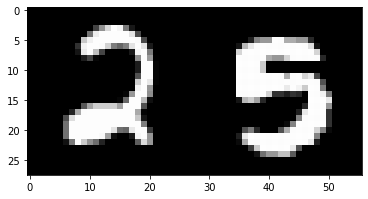

In [ ]:
# Randomly display an example from the new dataset formed.
random = np.random.randint(dataset_size)
plt.imshow(x[random], cmap = 'gray')
print(y[random])

In [ ]:
def ml_split(x, y):
    '''
    Multi hot encode the target variable and divide the data into train, validation and test data.
    '''
    # ml = MultiLabelBinarizer()
    # y = ml.fit_transform(y)

    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

    ml = MultiLabelBinarizer()
    y_train = ml.fit_transform(y_train)
    y_valid = ml.transform(y_valid)
    y_test = ml.transform(y_test)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = ml_split(x, y)

In [ ]:
def print_shapes():
    print('Shapes of dataset:')
    print('Training dataset:')
    print(X_train.shape, y_train.shape)
    print('\nValidation dataset:')
    print(X_valid.shape, y_valid.shape)
    print('\nTesting dataset:')
    print(X_test.shape, y_test.shape)

In [ ]:
def format_input(features, labels):
    '''
    convert the numpy array (images), labels to tensor objects for training, add the channel dimension to the images.
    '''
    features = tf.convert_to_tensor(features)
    features = tf.expand_dims(features, axis = -1)

    labels = tf.convert_to_tensor(labels)

    return features, labels

In [ ]:
X_train, y_train = format_input(X_train, y_train)
X_valid, y_valid = format_input(X_valid, y_valid)
X_test, y_test = format_input(X_test, y_test)

print_shapes()

Shapes of dataset:
Training dataset:
(28866, 28, 56, 1) (28866, 10)

Validation dataset:
(9021, 28, 56, 1) (9021, 10)

Testing dataset:
(7217, 28, 56, 1) (7217, 10)


In [ ]:
def create_generator(bath_size):
    '''
    Creating generators for augmenting (none is mentioned right now), reshaping the data and for easy flow of data to the model.
    '''
    train_datagen = ImageDataGenerator(rescale = 1.0/255.0, dtype = 'float')

    valid_datagen = ImageDataGenerator(rescale = 1.0/255., dtype = 'float')

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle = True, seed = 42)
    valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size, seed = 42)
    test_generator = valid_datagen.flow(X_test, y_test, batch_size=batch_size, seed = 42)

    return train_generator, valid_generator, test_generator

In [ ]:
batch_size = 128
train_generator, valid_generator, test_generator = create_generator(batch_size)

In [ ]:
# define cnn model
def define_model(shape=(28, 56, 1), num_classes=10):
    '''
    Function to create model.
    '''
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
	# model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
	# model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(Dense(256, kernel_initializer='he_uniform'))
    model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_uniform'))
    model.add(Dense(64, kernel_initializer='he_uniform'))
	# model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    return model
    
model = define_model()

In [ ]:
model.summary() # display model summary

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 56, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 56, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 28, 32)        0         
_________________________________________________________________
activation_3 (Activation)    (None, 14, 28, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 28, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 28, 64)       

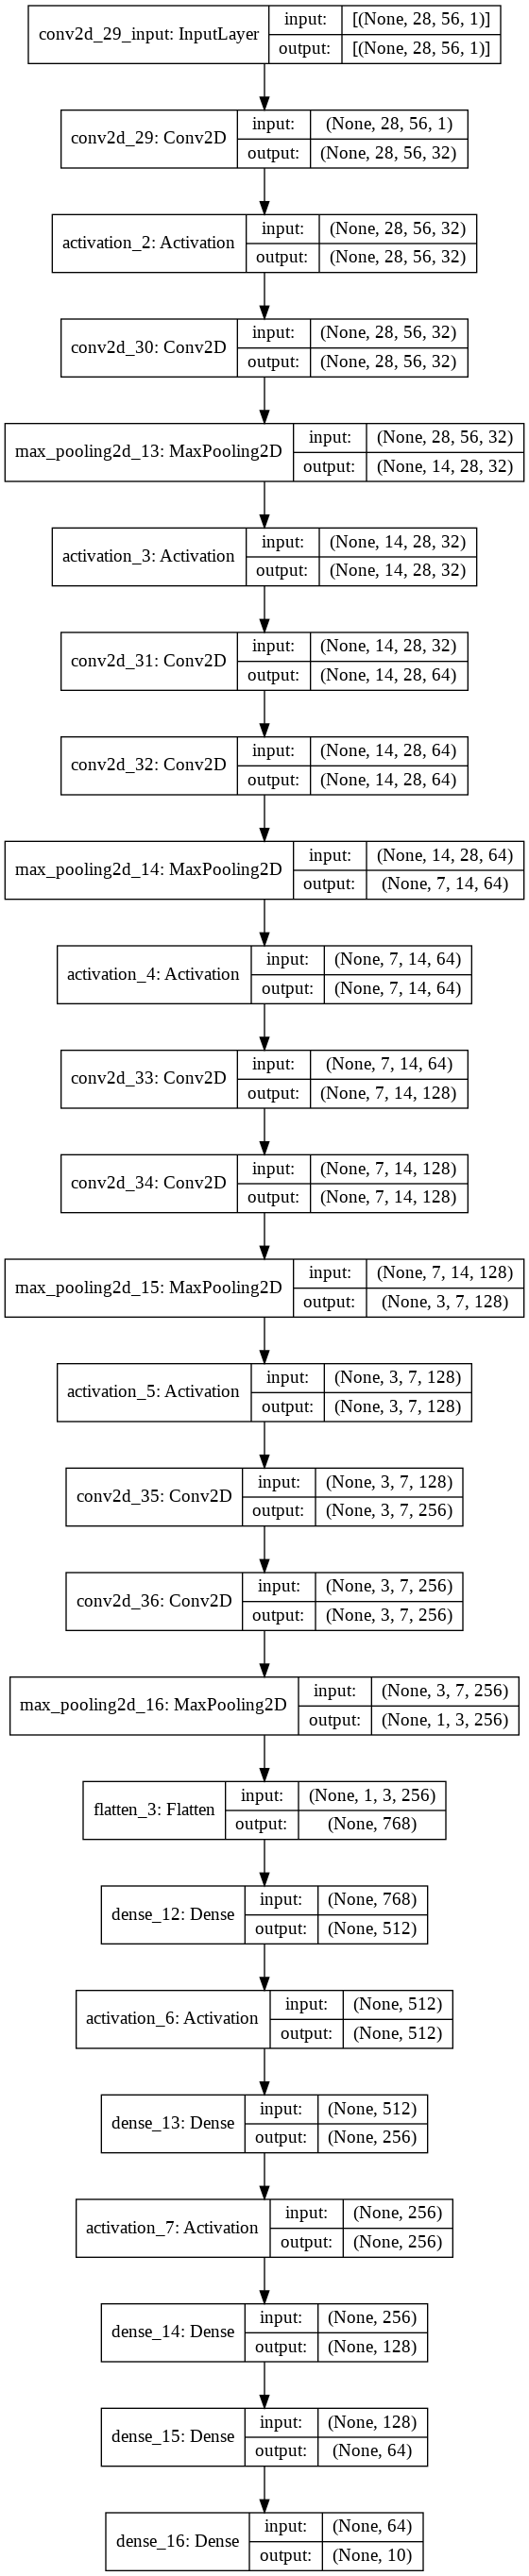

In [ ]:
plot_model(model, show_shapes = True)  # plot model

In [ ]:
# Define callbacks for the model, so that we can stop the training when required conditions are met.

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.75):
      print("\nReached 75% accuracy so cancelling training!")
      self.model.stop_training = True

es = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 25, verbose = 1, restore_best_weights=True,
                                      min_delta = 0.02)
callbacks = myCallback()

In [ ]:
opt = tf.keras.optimizers.Adagrad()
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
epochs = 500

hist = model.fit(train_generator, epochs = epochs, validation_data = valid_generator, callbacks=[callbacks, es])

Epoch 1/500
225/225 [==============================] - 5s 18ms/step - loss: 0.0606 - accuracy: 0.5705 - val_loss: 0.0686 - val_accuracy: 0.6047
Epoch 2/500
225/225 [==============================] - 4s 17ms/step - loss: 0.0558 - accuracy: 0.5804 - val_loss: 0.0651 - val_accuracy: 0.5789
Epoch 3/500
225/225 [==============================] - 4s 17ms/step - loss: 0.0522 - accuracy: 0.5770 - val_loss: 0.0644 - val_accuracy: 0.5709
Epoch 4/500
225/225 [==============================] - 4s 17ms/step - loss: 0.0498 - accuracy: 0.5743 - val_loss: 0.0636 - val_accuracy: 0.5843
Epoch 5/500
225/225 [==============================] - 4s 17ms/step - loss: 0.0482 - accuracy: 0.5795 - val_loss: 0.0609 - val_accuracy: 0.5740
Epoch 6/500
225/225 [==============================] - 4s 17ms/step - loss: 0.0465 - accuracy: 0.5811 - val_loss: 0.0590 - val_accuracy: 0.5804
Epoch 7/500
225/225 [==============================] - 4s 17ms/step - loss: 0.0449 - accuracy: 0.5784 - val_loss: 0.0585 - val_accuracy:

In [ ]:
# outputLabels = np.unique(y_train)

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced', outputLabels, y_train) 
# classWeight = dict(enumerate(classWeight))
# model.fit(train_generator, epochs = epochs, validation_data = (valid_generator), class_weight=classWeight, callbacks=[callbacks, es])

In [ ]:
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']

valid_acc = hist.history['val_accuracy']
valid_loss = hist.history['val_loss']
epochs = range(len(train_acc))

Text(0.5, 1.0, 'Accuracy')

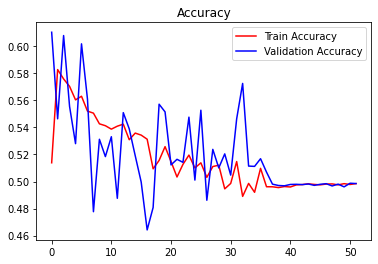

In [ ]:
plt.plot(epochs, train_acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, valid_acc, 'b', label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

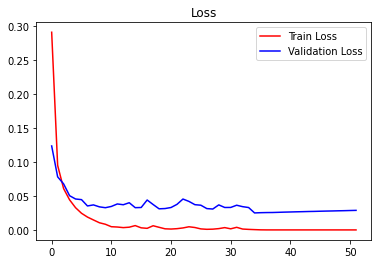

In [ ]:
plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
plt.legend()
plt.title('Loss')

In [ ]:
loss, accuracy = model.evaluate(test_generator, batch_size = batch_size)
print(loss)
print(int(accuracy * 100), '%')

57/57 [==============================] - 0s 7ms/step - loss: 0.0742 - accuracy: 0.5567
0.07424981892108917
55 %


In [ ]:
# model.save('mnist-2-2.h5')